In [2]:
from unet_val import UNet
import sys
import numpy as np
import os
import cv2
import logging
from image_utils import standardize,write_data_h5
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.backends.cudnn as cudnn
from dataset_generator_2 import Dataset_sat
from torch.utils.data import DataLoader
from IOU_computations import *
from resunet_main_fin import predict,criterion
from numpy import newaxis


/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%matplotlib inline

In [4]:
!gpustat

coeus  Thu Apr 26 18:53:38 2018
[0] TITAN X (Pascal) | 59'C,   1 % |  2157 / 12189 MB | s161362(2147M)
[1] TITAN X (Pascal) | 78'C,  53 % |  2103 / 12189 MB | s161362(2093M)
[2] TITAN X (Pascal) | 41'C,   0 % |     0 / 12189 MB |
[3] TITAN X (Pascal) | 34'C,   0 % |     0 / 12189 MB |
[4] TITAN X (Pascal) | 66'C,   0 % | 11157 / 12189 MB | s161362(11147M)
[5] TITAN X (Pascal) | 38'C,   0 % |     0 / 12189 MB |
[6] TITAN X (Pascal) | 36'C,   0 % |     0 / 12189 MB |
[7] TITAN X (Pascal) | 34'C,   1 % |     0 / 12189 MB |


In [5]:
SET='TEST/'
path_data='../2_DATA_GHANA/DATASET/120_x_120_8_pansh/'+SET
path_clean_data='../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/'+SET
if not os.path.exists(path_clean_data):
            os.makedirs(path_clean_data)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
path_wrong_data='../2_WRONG_DATA_GHANA/DATASET/120_x_120_8_pansh/'+SET
if not os.path.exists(path_wrong_data):
            os.makedirs(path_wrong_data)
path_model='MODEL_VAL_GHANA/RESUNET_val_ghana_restored2.ckptCP62000.pth'


In [6]:
INPUT_CHANNELS=9
NB_CLASSES=2
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DEFAULT_WIDTH_KERNEL=3
BATCH_SIZE=10

TMP_IOU='NEW_DATASET_TMP_IOU/'
if not os.path.exists(TMP_IOU):
        os.makedirs(TMP_IOU)
loss_fn=nn.CrossEntropyLoss()

Image 5, Validation IoU 0.4999, Validation IoU_acc 50.0000%,Validation F1 IoU 66.6667%, loss 0.00200038


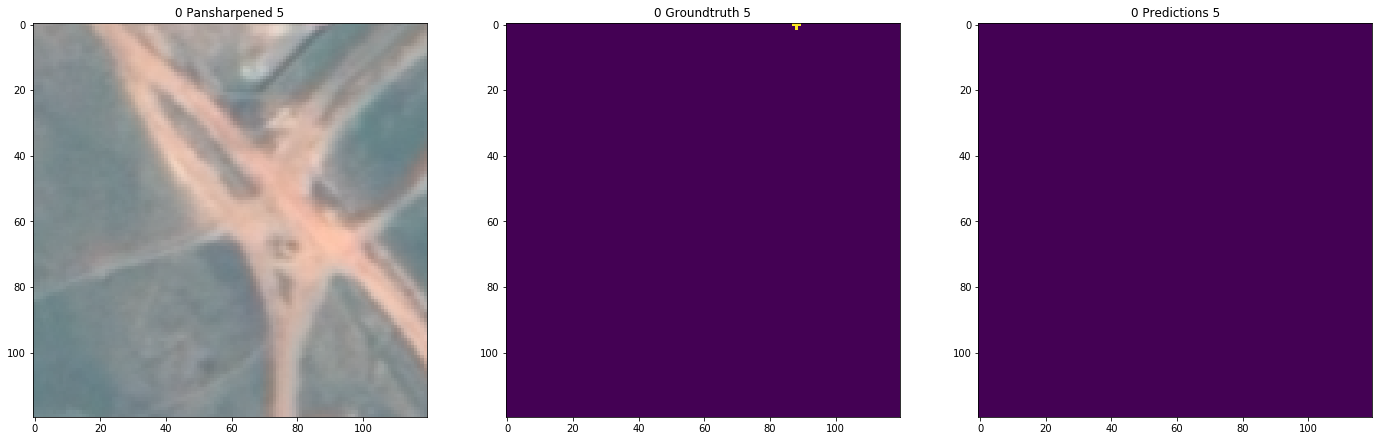

Is the grountruth true:Y or N?N
../2_WRONG_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_0.h5
Image 9, Validation IoU 0.1829, Validation IoU_acc 20.0000%,Validation F1 IoU 26.6667%, loss 0.52476132


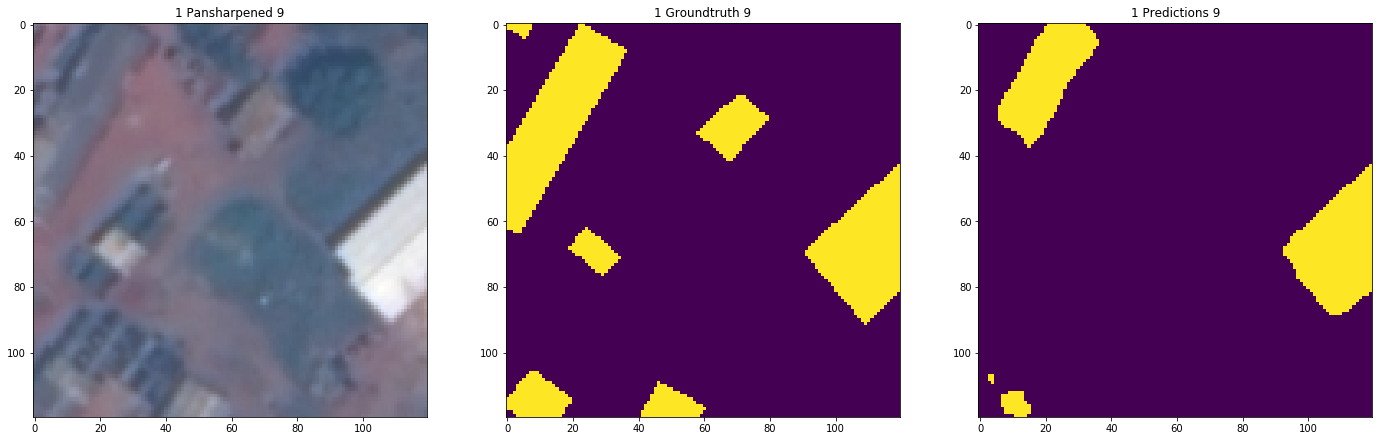

Is the grountruth true:Y or N?Y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_18.h5
Image 0, Validation IoU 0.6250, Validation IoU_acc 66.6667%,Validation F1 IoU 57.1429%, loss 0.03599339


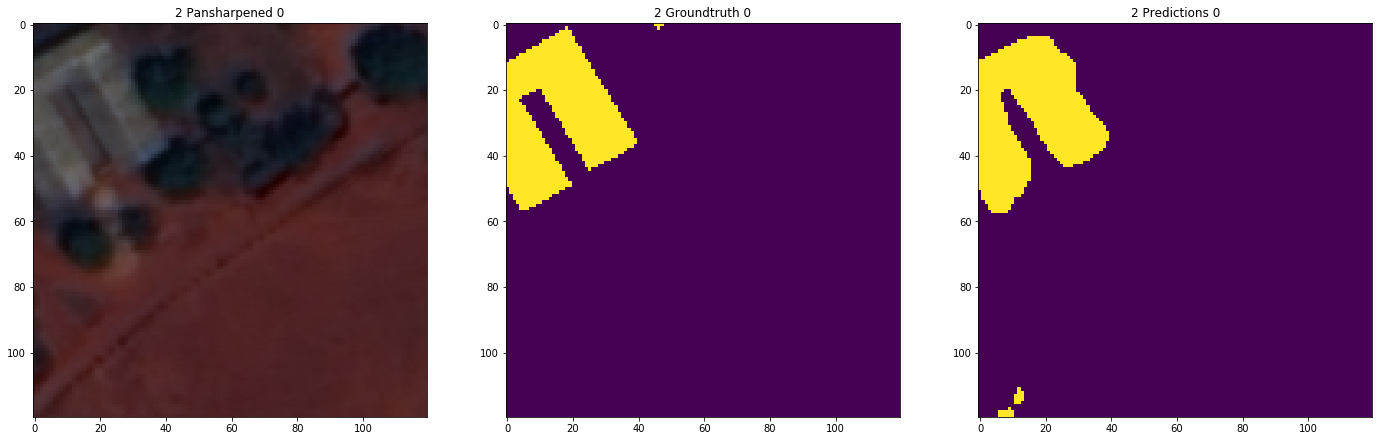

Is the grountruth true:Y or N?Y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_19.h5
Image 1, Validation IoU 0.3326, Validation IoU_acc 42.8571%,Validation F1 IoU 60.0000%, loss 0.34605944


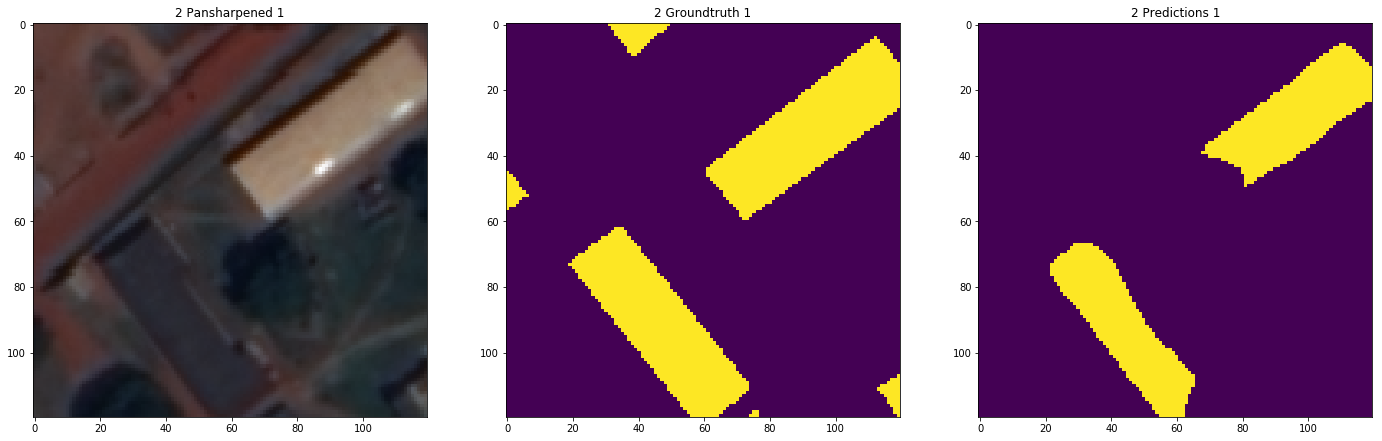

Is the grountruth true:Y or N?Y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_20.h5
Image 0, Validation IoU 0.2959, Validation IoU_acc 33.3333%,Validation F1 IoU 50.0000%, loss 1.51158154


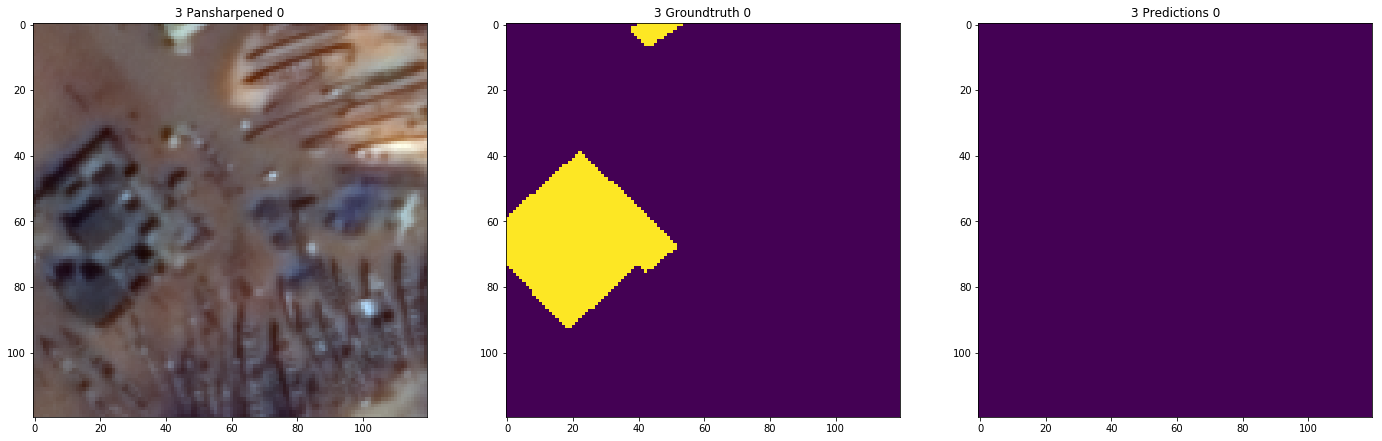

Is the grountruth true:Y or N?N
../2_WRONG_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_1.h5
Image 3, Validation IoU 0.4587, Validation IoU_acc 50.0000%,Validation F1 IoU 40.0000%, loss 0.36921006


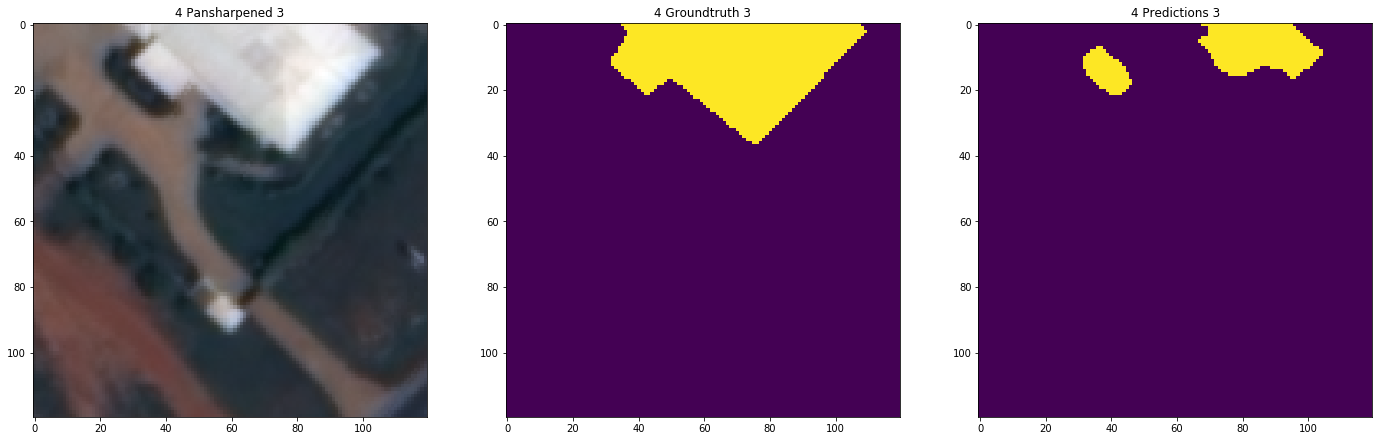

Is the grountruth true:Y or N?Y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_41.h5
Image 4, Validation IoU 0.3673, Validation IoU_acc 40.0000%,Validation F1 IoU 40.0000%, loss 0.23140976


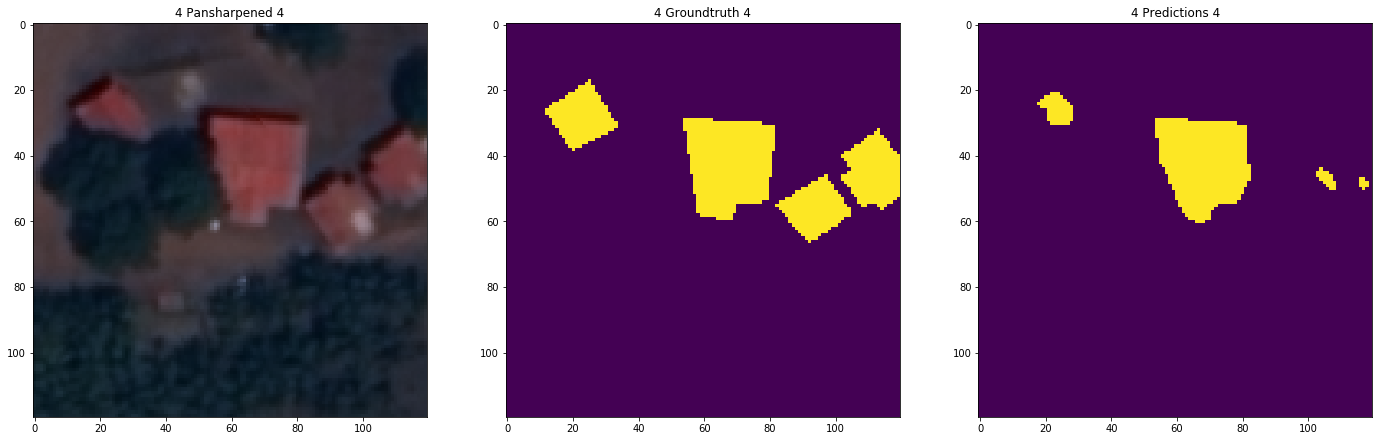

Is the grountruth true:Y or N?Y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_42.h5
Image 6, Validation IoU 0.4998, Validation IoU_acc 50.0000%,Validation F1 IoU 66.6667%, loss 0.00391804


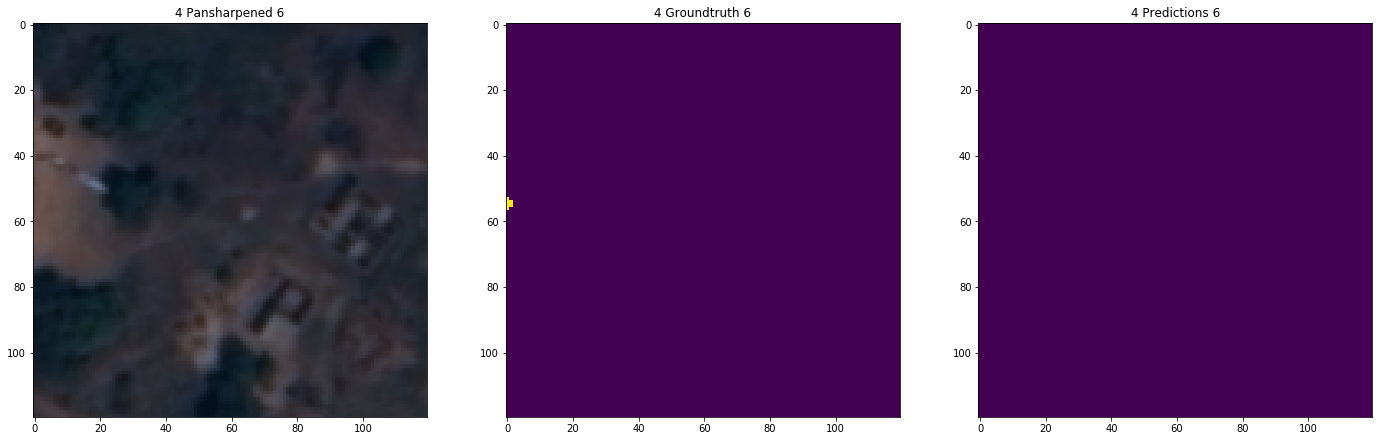

Is the grountruth true:Y or N?N
../2_WRONG_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_2.h5
Image 8, Validation IoU 0.0752, Validation IoU_acc 10.5263%,Validation F1 IoU 16.0000%, loss 1.37981939


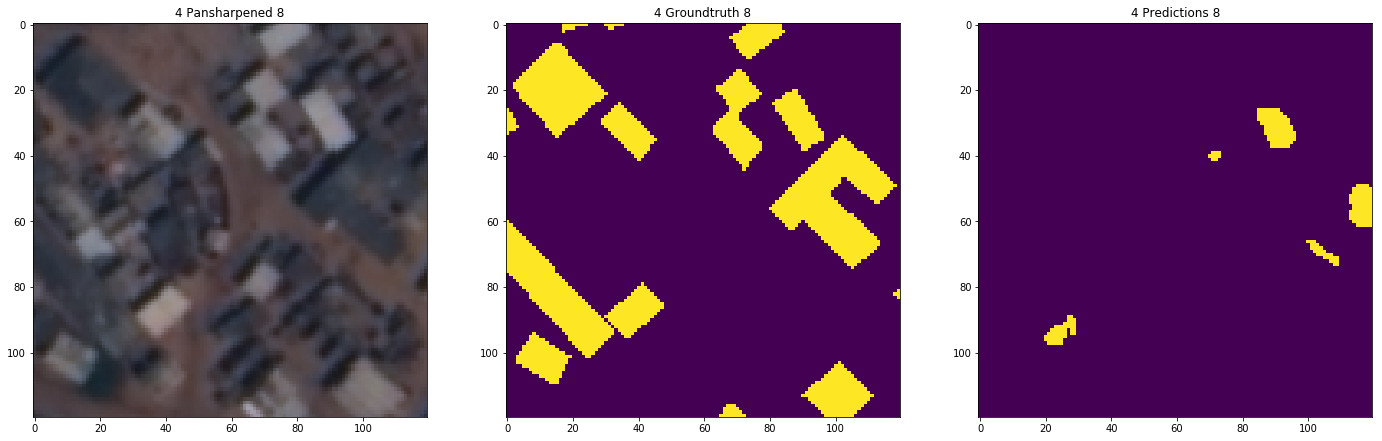

Is the grountruth true:Y or N?n
../2_WRONG_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_3.h5
Image 2, Validation IoU 0.5430, Validation IoU_acc 66.6667%,Validation F1 IoU 72.7273%, loss 0.07274012


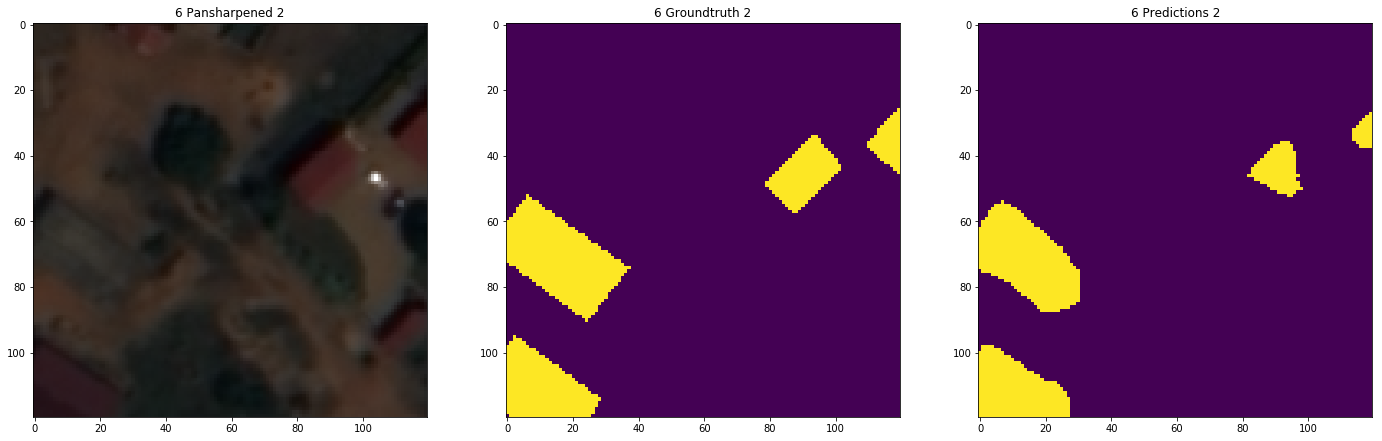

Is the grountruth true:Y or N?y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_58.h5
Image 2, Validation IoU 0.4502, Validation IoU_acc 60.0000%,Validation F1 IoU 54.5455%, loss 0.11942675


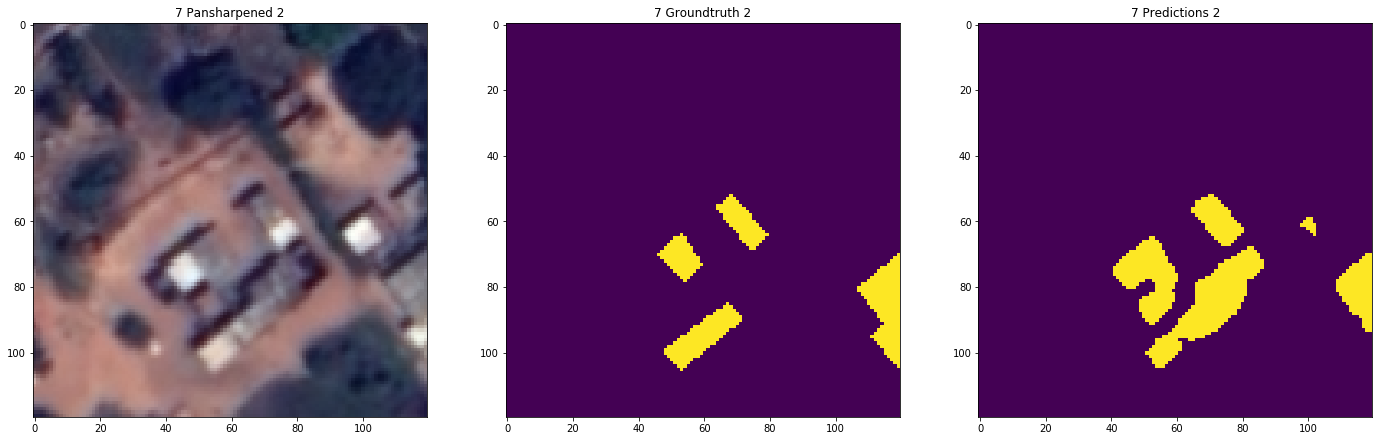

Is the grountruth true:Y or N?n
../2_WRONG_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_4.h5
Image 3, Validation IoU 0.5599, Validation IoU_acc 66.6667%,Validation F1 IoU 66.6667%, loss 0.11835881


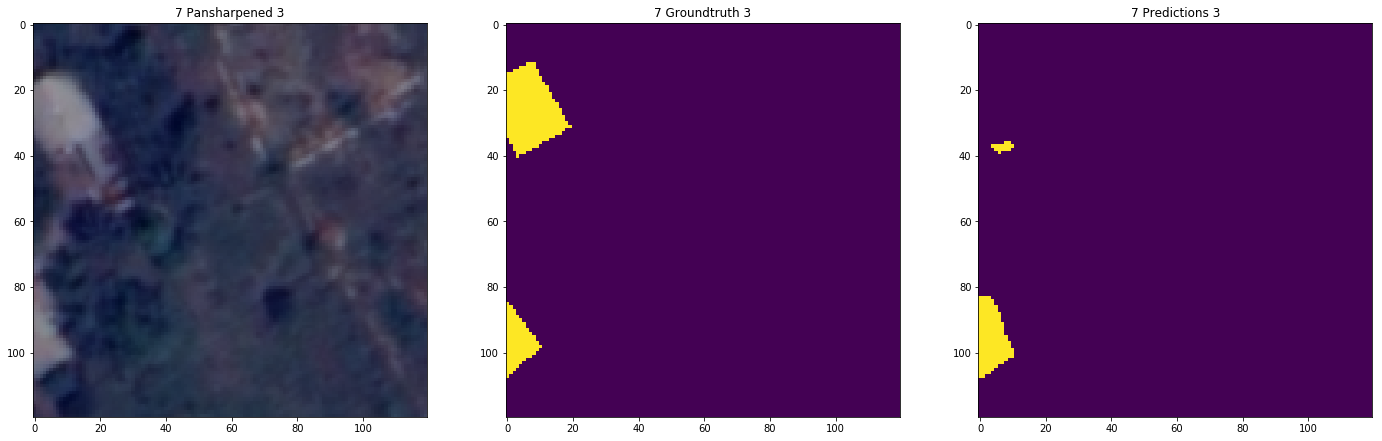

Is the grountruth true:Y or N?y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_68.h5
Image 8, Validation IoU 0.4978, Validation IoU_acc 50.0000%,Validation F1 IoU 40.0000%, loss 0.00759120


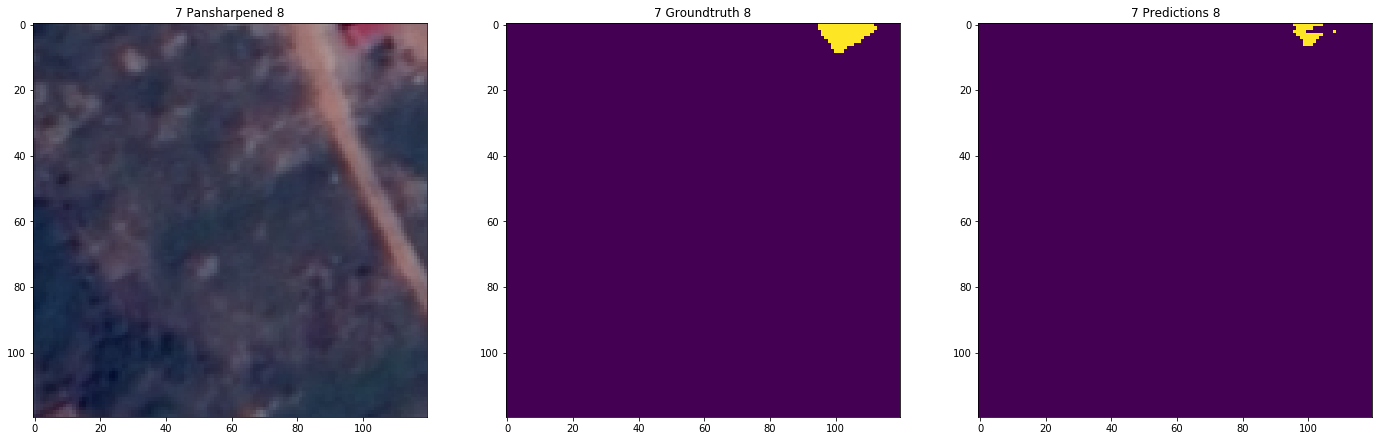

Is the grountruth true:Y or N?y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_73.h5
Image 1, Validation IoU 0.0722, Validation IoU_acc 11.7647%,Validation F1 IoU 14.2857%, loss 3.18565702


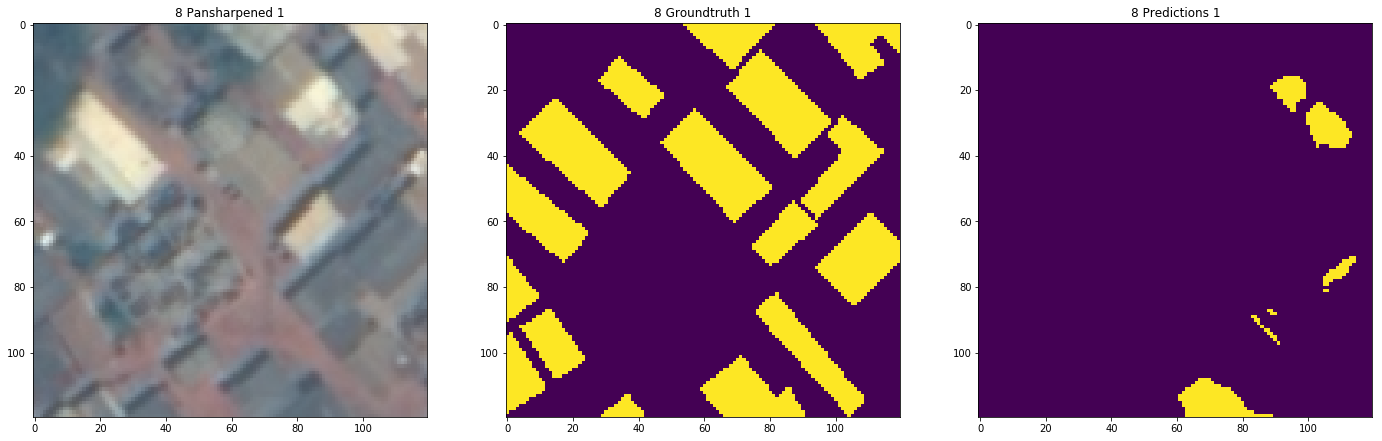

Is the grountruth true:Y or N?n
../2_WRONG_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_5.h5
Image 8, Validation IoU 0.3364, Validation IoU_acc 42.8571%,Validation F1 IoU 54.5455%, loss 0.59709358


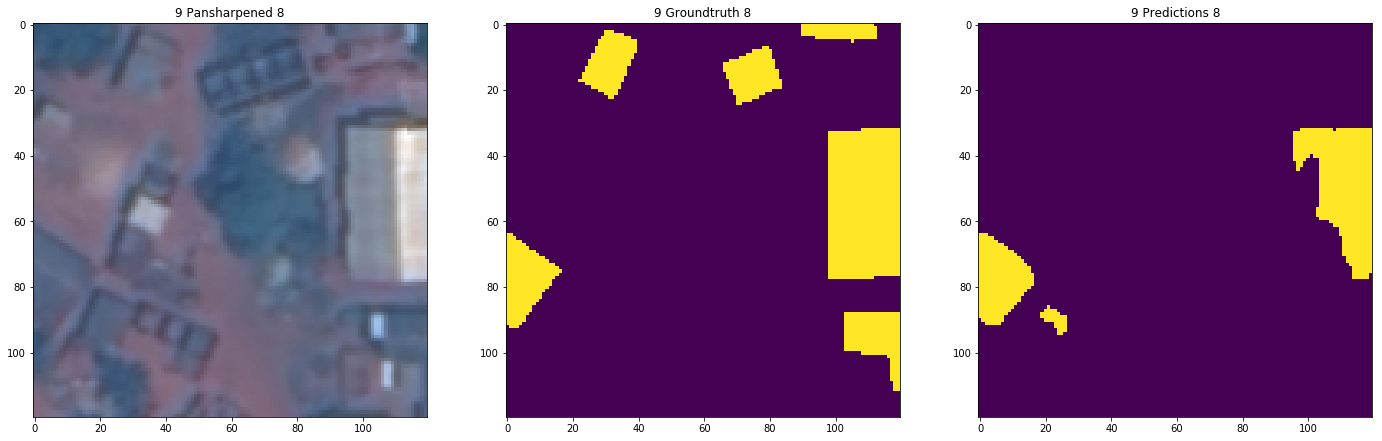

Is the grountruth true:Y or N?n
../2_WRONG_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_6.h5
Image 7, Validation IoU 0.4997, Validation IoU_acc 50.0000%,Validation F1 IoU 66.6667%, loss 0.00298860


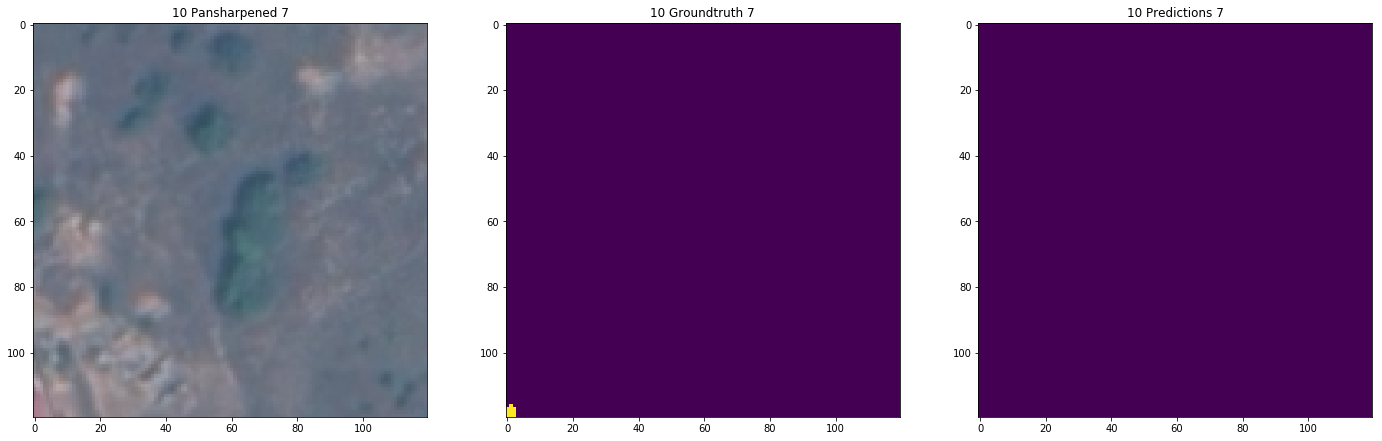

Is the grountruth true:Y or N?y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_100.h5
Image 2, Validation IoU 0.2104, Validation IoU_acc 25.0000%,Validation F1 IoU 40.0000%, loss 1.63421524


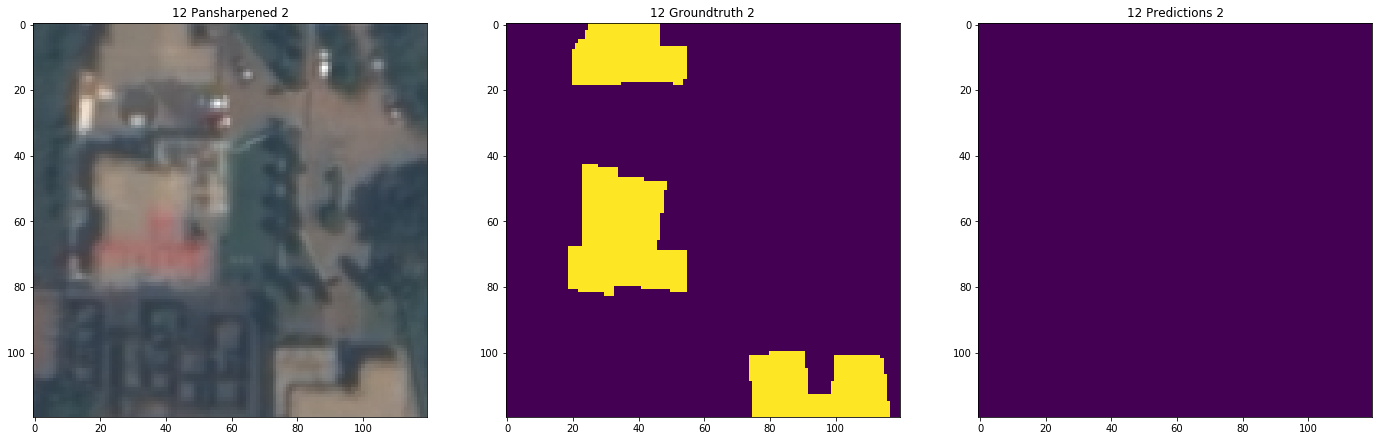

Is the grountruth true:Y or N?y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_115.h5
Image 5, Validation IoU 0.5269, Validation IoU_acc 66.6667%,Validation F1 IoU 75.0000%, loss 0.45703182


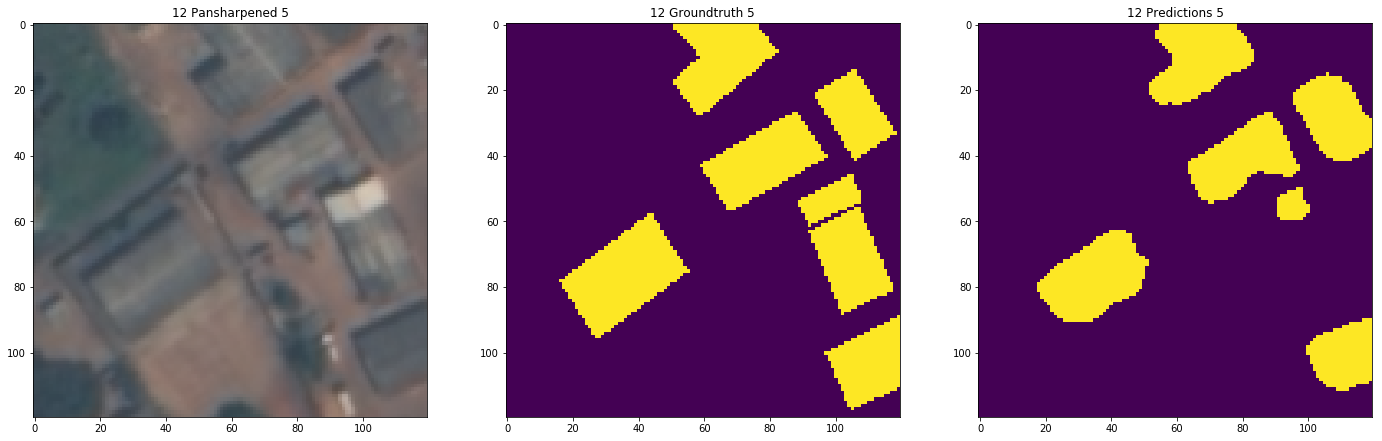

Process Process-3:
Traceback (most recent call last):
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/multiprocessing/connection.py", line 379,

KeyboardInterrupt: 

In [9]:


    
    
model=UNet(INPUT_CHANNELS,NB_CLASSES,depth=DEFAULT_LAYERS,n_features_zero=DEFAULT_FEATURES_ROOT,dropout=0,width_kernel=DEFAULT_WIDTH_KERNEL)
model.cuda()
cudnn.benchmark = True
model.load_state_dict(torch.load(path_model))

generator=Dataset_sat.from_root_folder(path_data,NB_CLASSES)
loader=DataLoader(generator, batch_size=BATCH_SIZE,shuffle=True, num_workers=1)
counter_good=0
counter_wrong=0
for i_batch,sample_batch in enumerate(loader):
    X_val=standardize(sample_batch['input'])
    Y_val=sample_batch['groundtruth']

    predictions=[]
    for j in range(len(X_val)):
        X_val_j=X_val[j]
        X_val_j=X_val_j[newaxis,:,:,:]
        X_val_j=standardize(X_val_j)
        Y_val_j=Y_val[j]
        Y_val_j=Y_val_j[newaxis,:,:,:]

        X = Variable(X_val_j.float())
        X=X.permute(0,3,1,2).cuda()  
        Y = Variable(Y_val_j.float())
        Y=Y.cuda()  

        predictions_i=predict(model,X)
        loss_i=criterion(Y,predictions_i)
        loss_i=loss_i.data[0]
        predictions_i=predictions_i.data.cpu().numpy()
        Y_val_j=np.asarray(Y_val_j)
        iou_acc_v,f1_v,iou_v=predict_score_batch(TMP_IOU,np.argmax(Y_val_j,3),np.argmax(predictions_i,3))
        
        if f1_v<100 and int(iou_acc_v)<100:
            print("Image {:d}, Validation IoU {:.4f}, Validation IoU_acc {:.4f}%,Validation F1 IoU {:.4f}%, loss {:.8f}".format(j,iou_v,iou_acc_v,f1_v,loss_i))

            fig,axs=plt.subplots(1, 3,figsize=(24,8))
            axs[0].set_title(str(i_batch)+' Pansharpened '+str(j), fontsize='large')
            axs[1].set_title(str(i_batch)+' Groundtruth '+str(j), fontsize='large')
            axs[2].set_title(str(i_batch)+' Predictions '+str(j), fontsize='large')
            pansharp=np.stack((X_val[j,:,:,5],X_val[j,:,:,3],X_val[j,:,:,2]),axis=2)
            axs[0].imshow(pansharp)
            axs[1].imshow(np.argmax(Y_val[j],2))
            axs[2].imshow(np.argmax(predictions_i[0],2))
            
            plt.show()
            answer=input('Is the grountruth true:Y or N?')
            if answer.lower()=='y':
                print(path_clean_data+'INPUT/input_'+str(counter_good)+'.h5')
                counter_good+=1
#                 write_data_h5(path_clean_data+'INPUT/input_'+str(counter_good)+'.h5',X_val[j])
#                 write_data_h5(path_clean_data+'OUTPUT/output_'+str(counter_good)+'.h5',np.argmax(Y_val[j],2))
            else:
                print(path_wrong_data+'INPUT/input_'+str(counter_wrong)+'.h5')
#                 write_data_h5(path_wrong_data+'INPUT/input_'+str(counter_wrong)+'.h5',X_val[j])
#                 write_data_h5(path_wrong_data+'OUTPUT/output_'+str(counter_wrong)+'.h5',np.argmax(Y_val[j],2))
                counter_wrong+=1
        else:
            
#             write_data_h5(path_clean_data+'INPUT/input_'+str(counter_good)+'.h5',X_val[j])
#             write_data_h5(path_clean_data+'OUTPUT/output_'+str(counter_good)+'.h5',np.argmax(Y_val[j],2))
            counter_good+=1

print('There are now %d elements in %s'%(counter_good,path_clean_data))
print('There are now %d elements in %s'%(counter_wrong,path_wrong_data))
